# Intercalated graphene
In this example, we extract the self-energies and Eliashberg function of
intercalated graphene.

Data have been provided with permission for re-use, originating from:
https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.085132


In [2]:
%load_ext autoreload
%autoreload 2

# Necessary packages
import xarpes
import matplotlib.pyplot as plt
import os

# Default plot configuration from xarpes.plotting.py
xarpes.plot_settings('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
script_dir = xarpes.set_script_dir()

dfld = 'data_sets'    # Folder containing the data
flnm = 'graphene_152' # Name of the file
extn = '.ibw'         # Extension of the file

data_file_path = os.path.join(script_dir, dfld, flnm + extn)

The following cell instantiates band map class object based on the Igor Binary Wave (ibw) file. The subsequent cell illustrates how a band map object could be instantiated with NumPy arrays instead. Only one of the cells will have to be executed to populate the band map object.

/home/tvanwaas/projects/xARPES/xarpes/plotting.py:72: UserWarning: Conversion from angle to momenta causes warping of the cell centers. 
 Cell edges of the mesh plot may look irregular.
  result = func(*args, **kwargs)


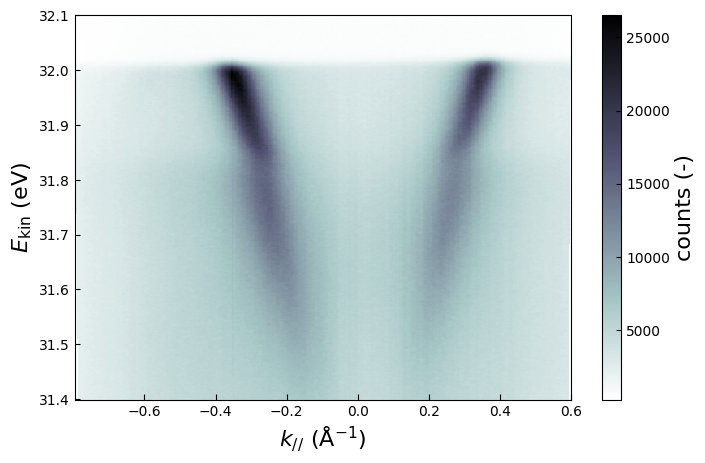

In [4]:
%matplotlib inline

bmap = xarpes.BandMap.from_ibw_file(data_file_path, energy_resolution=0.01, 
        angle_resolution=0.1, temperature=50)

bmap.shift_angles(shift=-2.28)

fig = plt.figure(figsize=(8, 5)); ax = fig.gca()

fig = bmap.plot(abscissa='momentum', ordinate='kinetic_energy', ax=ax)

In [5]:
# %matplotlib inline

# import numpy as np

# intensities= np.load(os.path.join(dfld, "graphene_152_intensities.npy"))
# angles = np.load(os.path.join(dfld, "graphene_152_angles.npy"))
# ekin = np.load(os.path.join(dfld, "graphene_152_ekin.npy"))

# bmap = xarpes.BandMap.from_np_arrays(intensities, angles, ekin, 
#         energy_resolution=0.01, angle_resolution=0.1, temperature=50)

# bmap.shift_angles(shift=-2.28)

# fig = plt.figure(figsize=(8, 5)); ax = fig.gca()

# fig = bmap.plot(abscissa='momentum', ordinate='kinetic_energy', ax=ax)

/home/tvanwaas/projects/xARPES/xarpes/plotting.py:72: UserWarning: Conversion from angle to momenta causes warping of the cell centers. 
 Cell edges of the mesh plot may look irregular.
  result = func(*args, **kwargs)


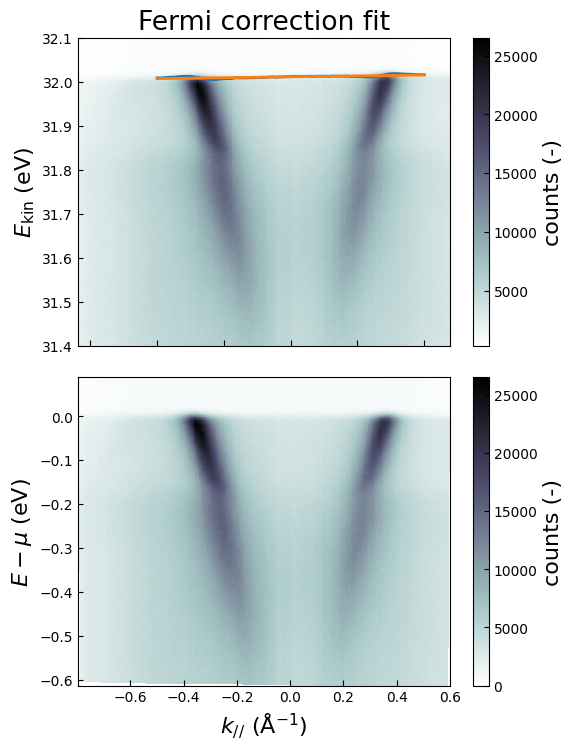

The optimised hnu - Phi=32.0120 +/- 0.00016 eV.


In [6]:
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

bmap.correct_fermi_edge(
      hnuminPhi_guess=32, background_guess=1e2,
      integrated_weight_guess=1e3, angle_min=-10, angle_max=10,
      ekin_min=31.96, ekin_max=32.1, true_angle=0,
      ax=ax[0], show=False, fig_close=False)

bmap.plot(ordinate='electron_energy', abscissa='momentum',
      ax=ax[1], show=False, fig_close=False)

# Figure customization
ax[0].set_xlabel(''); ax[0].set_xticklabels([])
ax[0].set_title('Fermi correction fit')
fig.subplots_adjust(top=0.92, hspace=0.1)
plt.show()

print('The optimised hnu - Phi=' + f'{bmap.hnuminPhi:.4f}' + ' +/- '
      + f'{1.96 * bmap.hnuminPhi_std:.5f}' + ' eV.')

# fig = bmap.plot(ordinate='kinetic_energy', abscissa='angle')

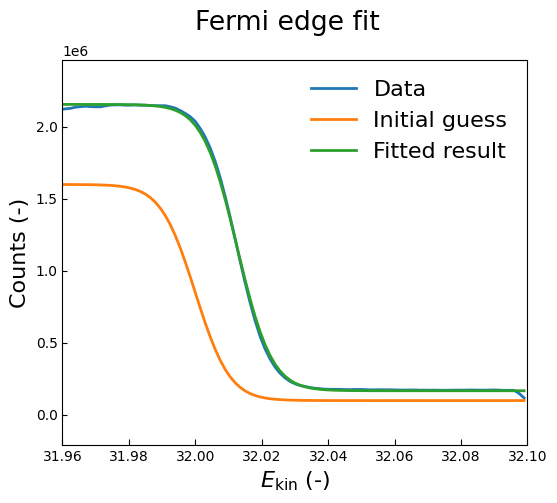

The optimised hnu - Phi=32.0126 +/- 0.00012 eV.


In [7]:
%matplotlib inline

fig = plt.figure(figsize=(6, 5))
ax = fig.gca()

fig = bmap.fit_fermi_edge(hnuminPhi_guess=32, background_guess=1e5,
                          integrated_weight_guess=1.5e6, angle_min=-10,
                          angle_max=10, ekin_min=31.96, ekin_max=32.1,
                          ax=ax, show=True, fig_close=True, title='Fermi edge fit')

print('The optimised hnu - Phi=' + f'{bmap.hnuminPhi:.4f}' + ' +/- '
      + f'{1.96 * bmap.hnuminPhi_std:.5f}' + ' eV.')

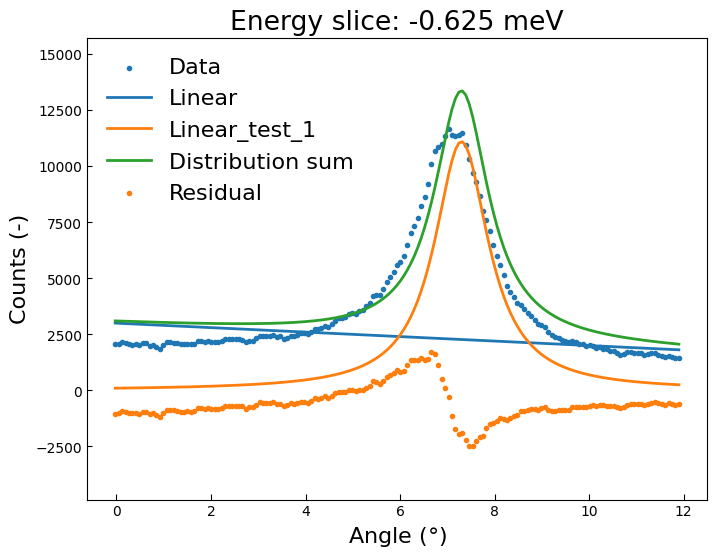

In [8]:
%matplotlib inline

angle_min = 0
angle_max = 1e6

energy_range = [-0.25, 0.01]
energy_value = 0

mdcs = xarpes.MDCs(*bmap.mdc_set(angle_min, angle_max, energy_range=energy_range))

guess_dists = xarpes.CreateDistributions([
xarpes.Linear(offset=3.0e3, slope=-100),
xarpes.SpectralLinear(amplitude=420, peak=7.3, broadening=0.012,
                      name='Linear_test', index='1')
])

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

fig = mdcs.visualize_guess(distributions=guess_dists, energy_value=energy_value, ax=ax)

**Note on interactive figures**
- The interactive figure might not work inside the Jupyter notebooks, despite our best efforts to ensure stability.
- As a fallback, the user may switch from "%matplotlib widget" to "%matplotlib qt", after which the figure should pop up in an external window.
- For some package versions, a static version of the interactive widget may spuriously show up inside other cells. In that case, uncomment the #get_ipython()... line in the first cell for your notebooks.

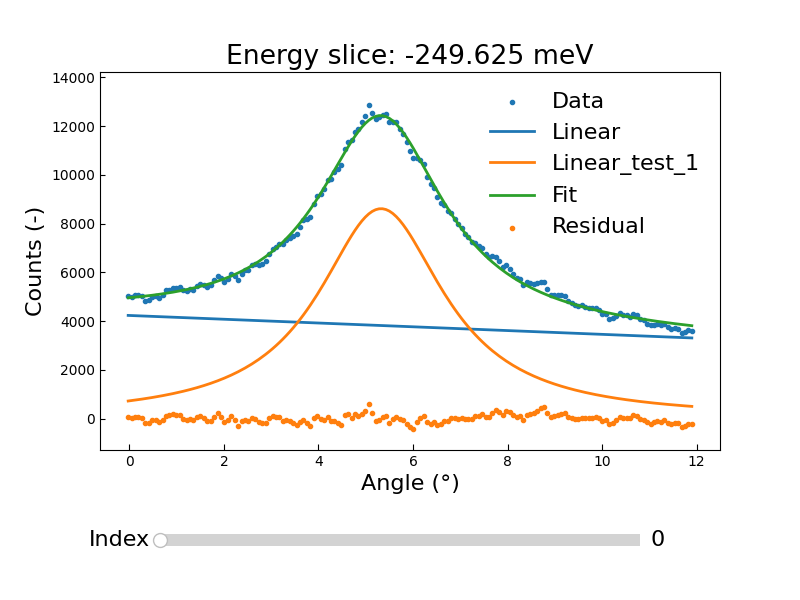

In [9]:
%matplotlib widget

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

mdcs = xarpes.MDCs(*bmap.mdc_set(angle_min, angle_max, energy_range=energy_range))

fig = mdcs.fit_selection(distributions=guess_dists, ax=ax)

/home/tvanwaas/projects/xARPES/xarpes/plotting.py:72: UserWarning: Conversion from angle to momenta causes warping of the cell centers. 
 Cell edges of the mesh plot may look irregular.
  result = func(*args, **kwargs)


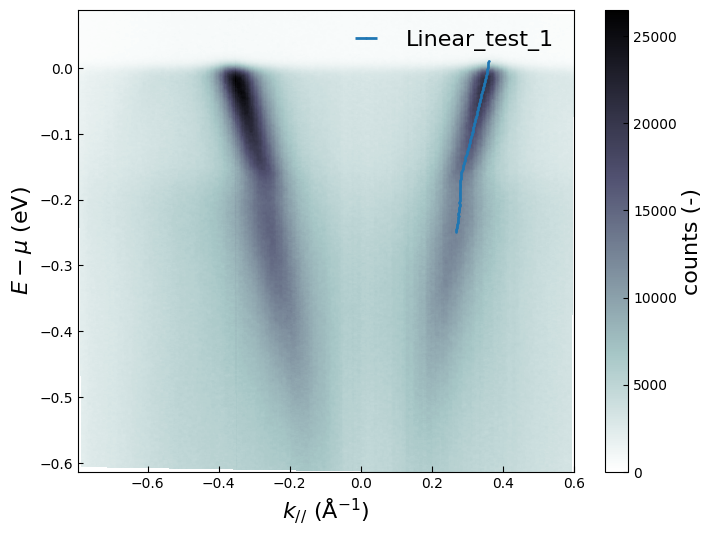

In [10]:
%matplotlib inline

plt.rcParams['lines.markersize'] = 0.8

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

self_energy = xarpes.SelfEnergy(*mdcs.expose_parameters(select_label='Linear_test_1',
                                fermi_velocity=2.85, fermi_wavevector=0.358))

self_energies = xarpes.CreateSelfEnergies([self_energy])

fig = bmap.plot(abscissa='momentum', ordinate='electron_energy', ax=ax,
                self_energies=self_energies)

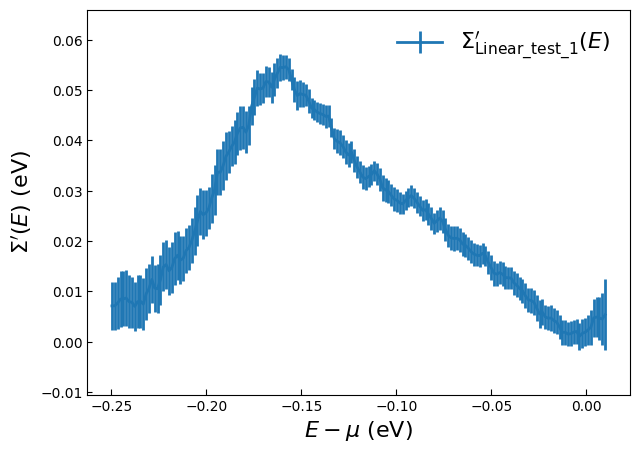

In [11]:
%matplotlib inline

xarpes.parameter_settings(new_sigma=4)

fig = plt.figure(figsize=(7, 5)); ax = fig.gca()

fig = self_energy.plot_real(ax=ax)

xarpes.parameter_settings(new_sigma=2)

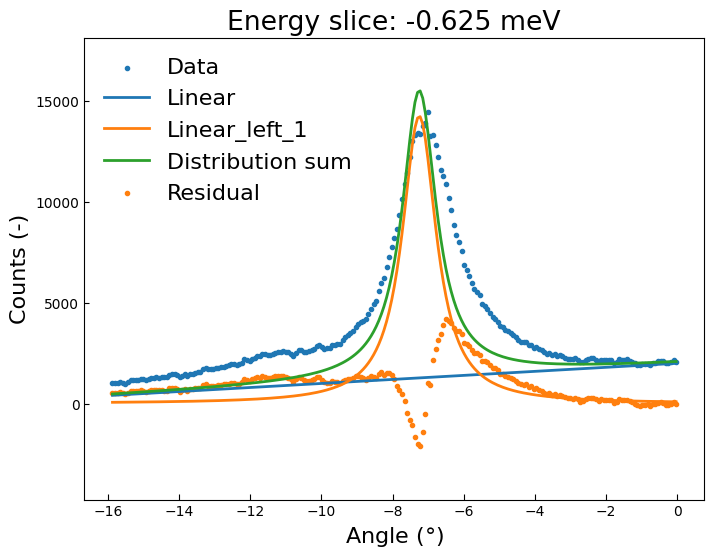

In [12]:
%matplotlib inline

angle_min2 = -1e6
angle_max2 = 0

plt.rcParams['lines.markersize'] = 3.0

mdc2 = xarpes.MDCs(*bmap.mdc_set(angle_min2, angle_max2, energy_range=energy_range))

guess_dists2 = xarpes.CreateDistributions([
xarpes.Linear(offset=2.0e3, slope=100),
xarpes.SpectralLinear(amplitude=450, peak=-7.25, broadening=0.01,
                      name='Linear_left', index='1'),
])

fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

fig = mdc2.visualize_guess(distributions=guess_dists2, energy_value=0, ax=ax)

In [13]:
# Fit without showing output

fig = mdc2.fit_selection(distributions=guess_dists2, show=False, fig_close=True)

self_left = xarpes.SelfEnergy(*mdc2.expose_parameters(select_label='Linear_left_1',
fermi_velocity=-2.67, fermi_wavevector=-0.354))

/home/tvanwaas/projects/xARPES/xarpes/plotting.py:72: UserWarning: Conversion from angle to momenta causes warping of the cell centers. 
 Cell edges of the mesh plot may look irregular.
  result = func(*args, **kwargs)
/home/tvanwaas/venvs/3.7_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


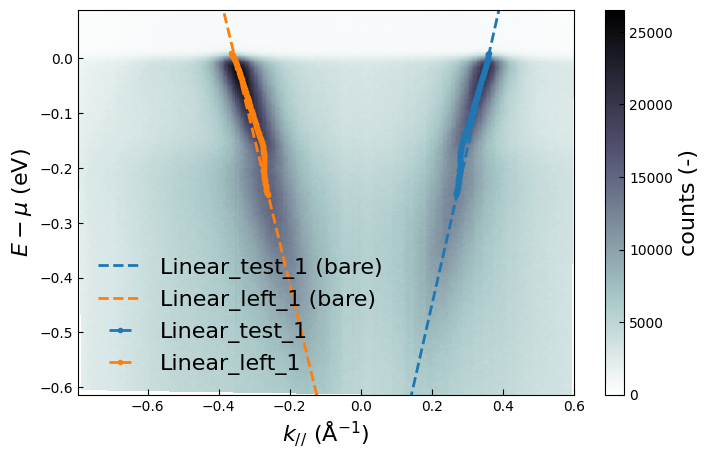

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(8, 5)); ax = fig.gca()

self_energies= xarpes.CreateSelfEnergies([
    self_energy, self_left
])

fig = bmap.plot(abscissa='momentum', ordinate='electron_energy',
                self_energies=self_energies, plot_dispersions='full',
                ax=ax)

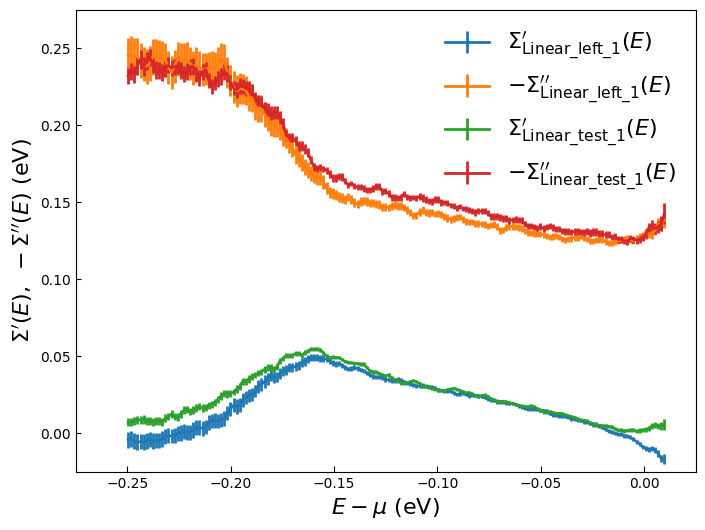

In [16]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

self_left.plot_both(ax=ax, show=False, fig_close=False)
self_energy.plot_both(ax=ax, show=False, fig_close=False)

ax.set_xlim([-0.275, 0.025])
ax.set_ylim([-0.025, 0.275])

plt.legend(); plt.show()

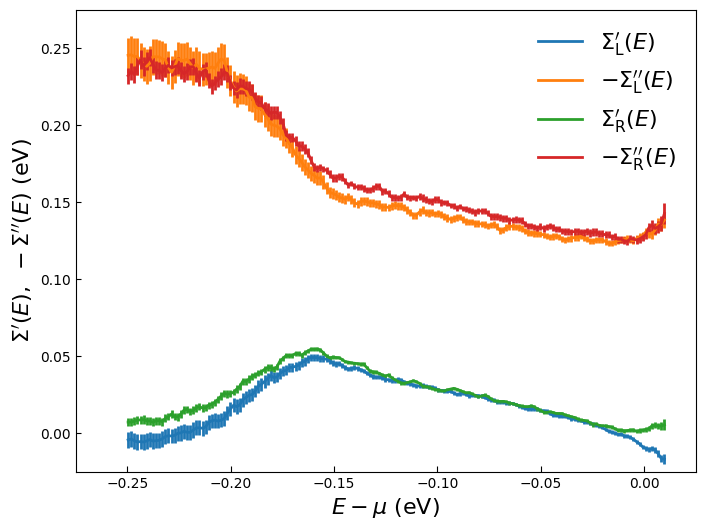

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

self_left.plot_both(ax=ax, show=False, fig_close=False)
self_energy.plot_both(ax=ax, show=False, fig_close=False)

ax.set_xlim([-0.275, 0.025]); ax.set_ylim([-0.025, 0.275])

# Replace labels with custom labels
left_real, left_imag, right_real, right_imag = ax.get_lines()

labels = [
    r"$\Sigma_{\mathrm{L}}'(E)$", r"$-\Sigma_{\mathrm{L}}''(E)$",
    r"$\Sigma_{\mathrm{R}}'(E)$", r"$-\Sigma_{\mathrm{R}}''(E)$",
]

ax.legend([left_real, left_imag, right_real, right_imag], labels)
plt.show()